# LIME interpretability for heartbeat classification with a multi-layer perceptron

In [1]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import *
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
sns.set()
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
length = 277
import lime
import lime.lime_tabular

### Extract task-specific data and one-hot encode labels

In [3]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Loading  ../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Build the multi-layer perceptron architecture and train the model

In [4]:
# Build a multi-layer perceptron:
def getModel():
    mlpmodel = Sequential()
    mlpmodel.add(Dense(100, activation = 'relu'))
    mlpmodel.add(Dense(9, activation = 'softmax'))
    return mlpmodel

mlpmodel = getModel()
mlpmodel.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy())

In [6]:
# Fit the model:
mlphistory = mlpmodel.fit(X_train, y_train, epochs = 100)

Epoch 1/100
998/998 [==============================] - 1s 477us/step - loss: 0.4178
Epoch 2/100
998/998 [==============================] - 0s 470us/step - loss: 0.1992
Epoch 3/100
998/998 [==============================] - 0s 460us/step - loss: 0.1551
Epoch 4/100
998/998 [==============================] - 0s 463us/step - loss: 0.1325
Epoch 5/100
998/998 [==============================] - 0s 453us/step - loss: 0.1161
Epoch 6/100
998/998 [==============================] - 0s 481us/step - loss: 0.1021
Epoch 7/100
998/998 [==============================] - 0s 463us/step - loss: 0.0933
Epoch 8/100
998/998 [==============================] - 0s 464us/step - loss: 0.0855
Epoch 9/100
998/998 [==============================] - 0s 463us/step - loss: 0.0814
Epoch 10/100
998/998 [==============================] - 0s 461us/step - loss: 0.0752
Epoch 11/100
998/998 [==============================] - 0s 460us/step - loss: 0.0700
Epoch 12/100
998/998 [==============================] - 0s 461us/step - lo

998/998 [==============================] - 0s 453us/step - loss: 0.0171
Epoch 98/100
998/998 [==============================] - 0s 478us/step - loss: 0.0131
Epoch 99/100
998/998 [==============================] - 0s 462us/step - loss: 0.0135
Epoch 100/100
998/998 [==============================] - 0s 464us/step - loss: 0.0148


In [9]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(mlpmodel, 'mlpmodel_lime_ecg.h5')

In [5]:
# Visualize the model:
mlpmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               27600     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 28,509
Trainable params: 28,509
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Make a prediction and show the accuracy:
pred = mlpmodel.predict(X_test)
accuracy_score(np.argmax(y_test, axis = 1), np.argmax(pred, axis = 1))

0.9465705305971529

### Create the explainer and explain an instance

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, discretize_continuous = True)
exp = explainer.explain_instance(X_test[50], mlpmodel.predict, labels = [np.argmax(y_test[50])], num_features = 275)

In [33]:
# Get the weights for all features:
map_explanation = exp.as_map()[np.argmax(y_test[50])]
features, weights = [], []
for e in map_explanation:
    features.append(e[0])
    weights.append(e[1])
features = np.array(features)
weights = np.array(weights)

# Sort based on features:
indices_sort = np.argsort(features)
features = features[indices_sort]
weights = weights[indices_sort]

# Average over the actual variables:
mean_weights = np.zeros((11, ))
for i in range(0, 275, 25):
    mean_weights[i // 25] = np.mean(weights[i:i+25])

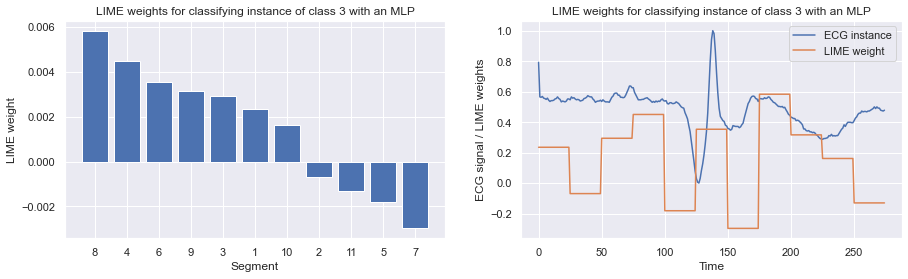

In [35]:
# Sort based on weight:
indices_sort = np.argsort(-1 * mean_weights)
slices = np.arange(1, 12)

# Visualize:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_weights[indices_sort])
ax[0].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[50])) + ' with an MLP')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort])
ax[0].set_ylabel('LIME weight')
ax[0].set_xlabel('Segment')

ecg_normalized = (X_test[50, :] - X_test[50, :].min()) / (X_test[50, :].max() - X_test[50, :].min())
ax[1].plot(np.arange(275), ecg_normalized, label = 'ECG instance')
ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'LIME weight')
ax[1].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[50])) + ' with an MLP')
ax[1].set_ylabel('ECG signal / LIME weights')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.savefig('lime_weights_x50_MLP.jpg', dpi = 400)

### Explain another instance of another class

In [37]:
exp = explainer.explain_instance(X_test[100], mlpmodel.predict, labels = [np.argmax(y_test[100])], num_features = 275)

In [38]:
# Get the weights for all features:
map_explanation = exp.as_map()[np.argmax(y_test[100])]
features, weights = [], []
for e in map_explanation:
    features.append(e[0])
    weights.append(e[1])
features = np.array(features)
weights = np.array(weights)

# Sort based on features:
indices_sort = np.argsort(features)
features = features[indices_sort]
weights = weights[indices_sort]

# Average over the actual variables:
mean_weights = np.zeros((11, ))
for i in range(0, 275, 25):
    mean_weights[i // 25] = np.mean(weights[i:i+25])

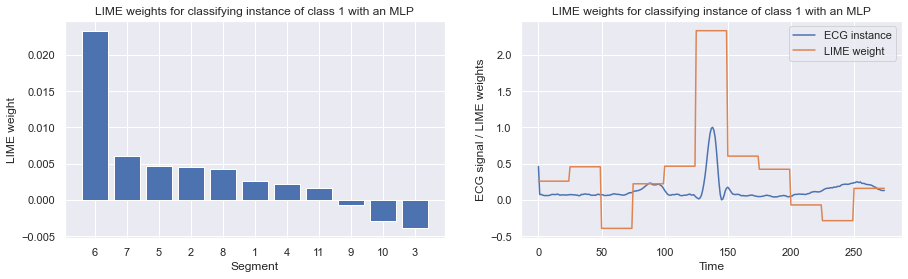

In [41]:
# Sort based on weight:
indices_sort = np.argsort(-1 * mean_weights)
slices = np.arange(1, 12)

# Visualize:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_weights[indices_sort])
ax[0].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[100])) + ' with an MLP')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort])
ax[0].set_ylabel('LIME weight')
ax[0].set_xlabel('Segment')

ecg_normalized = (X_test[100, :] - X_test[100, :].min()) / (X_test[100, :].max() - X_test[100, :].min())
ax[1].plot(np.arange(275), ecg_normalized, label = 'ECG instance')
ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'LIME weight')
ax[1].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[100])) + ' with an MLP')
ax[1].set_ylabel('ECG signal / LIME weights')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.savefig('lime_weights_x100_MLP.jpg', dpi = 400)